Session 7 Task 2

Problem statement:
Design this network (CIFAR10):
1. Image result for eNAS network architecture
2. The lines you see are the skip-connections. You need to add them
3. Train for 100 Epochs (add BN and ReLU after every layer)
4. Submit the results


Importing al necessary keras, matplot, numpy libs

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, DepthwiseConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#preparing check point for saving weights via callback
from google.colab import drive
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing, loading data in train and test

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

Viewsing train data for labels.

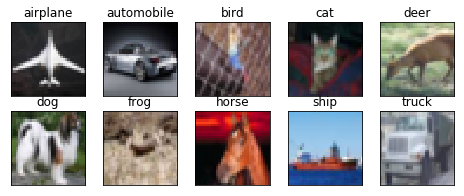

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Defigning function to plot model training validation accuracy and loss

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Defining function to find and return accracy of trained model in percentage

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Normalizing train and test data 
Converting labels from 1-D to 2-D with leangth of second dimention is num_class

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Defining ENAS network arch

In [8]:
#Defining model

#importing necessary modules
from keras.models import Model
from keras.layers import Input, Flatten, Conv2D
from keras.layers.merge import concatenate

# input layer
visible = Input(shape=(32,32,3))

# layer1 Sep 5x5 
layer11 = Conv2D(32, (3, 3), padding="same", activation='relu') (visible)
layer12 = Conv2D(32, (3, 1), padding="same", activation='relu') (layer11)
layer1 = Conv2D(32, (1, 3), padding="same", activation='relu') (layer12)
layer1 = (BatchNormalization())(layer1) 

# layer2 conv 5x5
layer21 = Conv2D(32, (3, 3), padding="same", activation='relu') (layer1)
layer2 = Conv2D(32, (3, 3), padding="same", activation='relu') (layer21)
layer2 = (BatchNormalization())(layer2) 

# layer3 conc 5x5
layer31 = Conv2D(32, (3, 3), padding="same", activation='relu') (layer2)
layer3 = Conv2D(32, (3, 3), padding="same", activation='relu') (layer31)
layer3 = (BatchNormalization())(layer3) 

# layer4 Sep 5x5 from 1
layer41 = Conv2D(32, (3, 3), padding="same", activation='relu') (concatenate([layer1, layer3]))
layer42 = Conv2D(32, (3, 1), padding="same", activation='relu') (layer41)
layer4 = Conv2D(32, (1, 3), padding="same", activation='relu') (layer42)
layer4 = (BatchNormalization())(layer4) 

# pool1 maxpooling skip from 1
btl_nek1 = Conv2D(16, (1, 1), padding="same", activation='relu') (concatenate([layer1, layer4]))
pool1 = MaxPooling2D(pool_size=(2, 2), padding="same", strides=1) (btl_nek1)

# layer5 sep 3x3 
layer51 = Conv2D(32, (3, 1), padding="same", activation='relu') (pool1)
layer5 = Conv2D(32, (1, 3), padding="same", activation='relu') (layer51)
layer5 = (BatchNormalization())(layer5) 

# layer6 conv 5x5 skip from 1,4
layer61 = Conv2D(32, (3, 3), padding="same", activation='relu') (concatenate([layer1, layer4, layer5]))
layer6 = Conv2D(32, (3, 3), padding="same", activation='relu') (layer61)
layer6 = (BatchNormalization())(layer6) 

# layer7 sep 3x3 skip from 3,4,5
layer71 = Conv2D(32, (3, 1), padding="same", activation='relu') (concatenate([layer3, layer4, layer5, layer6]))
layer7 = Conv2D(32, (1, 3), padding="same", activation='relu') (layer71)
layer7 = (BatchNormalization())(layer7) 

# layer8 sep 5x5 skip from 1,3,4,5,6
layer81 = Conv2D(32, (3, 3), padding="same", activation='relu') (concatenate([layer1, layer3, layer4, layer5, layer6, layer7]))
layer82 = Conv2D(32, (3, 1), padding="same", activation='relu') (layer81)
layer8 = Conv2D(32, (1, 3), padding="same", activation='relu') (layer82)
layer8 = (BatchNormalization())(layer8) 

# pool2 maxpooling skip from 1,4,5,7
btl_nek10 = Conv2D(16, (1, 1), padding="same", activation='relu') (concatenate([layer1, layer4, layer5, layer7, layer8]))
pool2 = MaxPooling2D(pool_size=(2, 2), padding="same", strides=1) (btl_nek10)

# layer9 conv 5x5 skip from 6
layer91 = Conv2D(32, (3, 3), padding="same", activation='relu') (concatenate([layer6, pool2]))
layer9 = Conv2D(32, (3, 3), padding="same", activation='relu') (layer91)
layer9 = (BatchNormalization())(layer9) 

# layer10 sep 5x5 skip from 1,2,4,7
layer101 = Conv2D(32, (3, 3), padding="same", activation='relu') (concatenate([layer1, layer2, layer4, layer7, layer9]))
layer102 = Conv2D(32, (3, 1), padding="same", activation='relu') (layer101)
layer10 = Conv2D(32, (1, 3), padding="same", activation='relu') (layer102)
layer10 = (BatchNormalization())(layer10) 

# layer11 conv 3x3 skip from 2,3,5,9
layer11 = Conv2D(32, (3, 3), padding="same", activation='relu') (concatenate([layer2, layer3, layer5, layer9, layer10]))
layer11 = (BatchNormalization())(layer11) 
  
# layer12 sep 5x5 skip from 3,4,5,7,10
layer121 = Conv2D(32, (3, 3), padding="same", activation='relu') (concatenate([layer3, layer4, layer5, layer7, layer10, layer11]))
layer122 = Conv2D(32, (3, 1), padding="same", activation='relu') (layer121)
layer12 = Conv2D(32, (1, 3), padding="same") (layer122)
layer12 = (BatchNormalization())(layer12) 

# last part skip from 4,8,12
flat = Flatten()(concatenate([layer4, layer7, layer10, layer12]))
last = Dense(10)(flat)
output = Dense(10, activation='softmax')(last)
model = Model(inputs=visible, outputs=output)

W0616 10:19:13.007233 139871098079104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 10:19:13.048682 139871098079104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 10:19:13.057359 139871098079104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 10:19:13.162026 139871098079104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0616 10:19:13.166854 1398710980

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   3104        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   3104        conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [10]:
#Adding lr rate scheduling and model saving
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
def scheduler(epoch, lr):
  return round(0.001 * 1/(1 + 0.319 * epoch), 10)

filepath="/content/gdrive/My Drive/Weights/Session7Task2_final_weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callback_list = [checkpoint] #[LearningRateScheduler(scheduler, verbose=1), checkpoint]

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


W0616 10:19:38.073337 139871098079104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Training for Epochs = 100

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 32),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), verbose=1, 
                                 callbacks=callback_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Epoch 1/20
   1/1562 [..............................] - ETA: 2:57 - loss: 13.5996 - acc: 0.1562

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=1562, epochs=20)`
  


1562/1562 [==============================] - 144s 92ms/step - loss: 12.7953 - acc: 0.2055 - val_loss: 13.2990 - val_acc: 0.1747

Epoch 00001: val_acc did not improve from 0.27650
Epoch 2/20
1562/1562 [==============================] - 82s 52ms/step - loss: 12.9115 - acc: 0.1983 - val_loss: 12.2047 - val_acc: 0.2426

Epoch 00002: val_acc did not improve from 0.27650
Epoch 3/20
1562/1562 [==============================] - 127s 81ms/step - loss: 12.5059 - acc: 0.2236 - val_loss: 12.2830 - val_acc: 0.2376

Epoch 00003: val_acc did not improve from 0.27650
Epoch 4/20
1562/1562 [==============================] - 158s 101ms/step - loss: 12.7250 - acc: 0.2098 - val_loss: 12.8618 - val_acc: 0.2010

Epoch 00004: val_acc did not improve from 0.27650
Epoch 5/20
1562/1562 [==============================] - 157s 101ms/step - loss: 12.6231 - acc: 0.2162 - val_loss: 12.6593 - val_acc: 0.2141

Epoch 00005: val_acc did not improve from 0.27650
Epoch 6/20
1562/1562 [==============================] - 158s

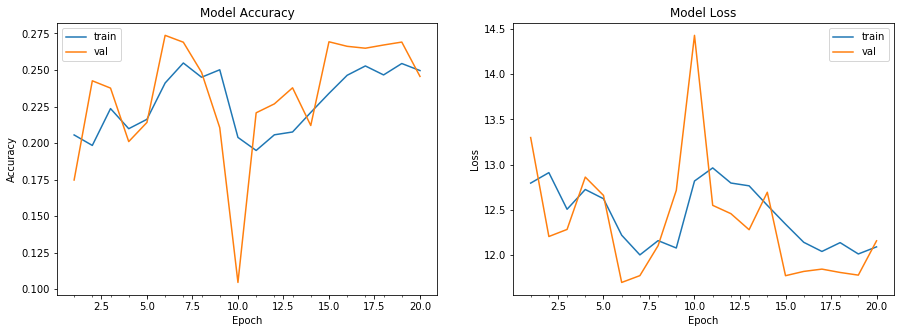

Accuracy on test data is: 24.56


In [12]:
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 32),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 20, 
                                 validation_data = (test_features, test_labels), verbose=1, 
                                 callbacks=callback_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))